# Importando dependencias e explorando o dataset


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
df = pd.read_csv('faults.csv')
df



,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,-0.4286,0.0026,0.7254,0,0,0,0,0,0,1
1937,144,175,340581,340598,287,44,24,34599,112,133,...,-0.4516,-0.0582,0.8173,0,0,0,0,0,0,1
1938,145,174,386779,386794,292,40,22,37572,120,140,...,-0.4828,0.0052,0.7079,0,0,0,0,0,0,1
1939,137,170,422497,422528,419,97,47,52715,117,140,...,-0.0606,-0.0171,0.9919,0,0,0,0,0,0,1


In [ ]:
# Supondo que as 7 últimas colunas sejam as classes:
class_columns = df.columns[-7:]

# Conta quantas amostras em cada classe (assumindo que one-hot tem um "1" por linha)
class_distribution = df[class_columns].sum()

print(class_distribution)

* Tenho 1941 Linhas de dados e onde as ultimas 7 sao labels organizadas de forma one hot para classificar

* Problema que tem classes como stains e bumps que sao pequenos de mais em relacao aos outros 

* Utilizar SMOTE para equilibrar o dataset e tentar melhorar a precisao


In [ ]:
# 3. Definir X e y
df[class_columns] = df[class_columns].apply(pd.to_numeric, errors='coerce')
X = df_dropped = df.iloc[:, :-7]
y = df[class_columns].idxmax(axis=1)
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, stratify=y, random_state=42)
print("Antes do SMOTE:\n", y_train.value_counts())


In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
print("ADASYN:\n", y_train_res.value_counts())

# Dados Foram Balanceados aplicando LDA ou PCA, Obtive piora no desempenho

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=None)
X_train_lda = lda.fit_transform(X_train_res, y_train_res)
X_test_lda = lda.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA

# Ex: reduzir para 15 componentes
pca = PCA(n_components=20, random_state=42)
X_train_pca = pca.fit_transform(X_train_res)
X_test_pca = pca.transform(X_test)


In [ ]:
pca = PCA().fit(X_train_res)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('% de Variância Explicada')
plt.grid()
plt.show()

In [65]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Codificar rótulos
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_res)

# Gerar os pesos com base em rótulos codificados
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
weight_dict = dict(zip(np.unique(y_train_encoded), class_weights))

# Exemplo: aumentar manualmente o peso da classe Pastry (que deve ter sido codificada como algum número)
pastry_index = np.where(le.classes_ == 'Pastry')[0][0]
bump_index = np.where(le.classes_ == 'Bumps')[0][0]
weight_dict[pastry_index] *= 8



In [55]:
param_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 7]
}
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_rf,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)
rf_grid.fit(X_train_res, y_train_res)
print("🎯 Melhor RF:", rf_grid.best_params_)
print(classification_report(y_test, rf_grid.predict(X_test)))

🎯 Melhor RF: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

       Bumps       0.73      0.74      0.74        81
   Dirtiness       0.91      0.91      0.91        11
    K_Scatch       0.97      0.95      0.96        78
Other_Faults       0.79      0.76      0.78       135
      Pastry       0.57      0.72      0.64        32
      Stains       0.86      0.86      0.86        14
   Z_Scratch       0.94      0.89      0.92        38

    accuracy                           0.81       389
   macro avg       0.83      0.83      0.83       389
weighted avg       0.82      0.81      0.81       389



In [46]:
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True, random_state=42, ))
])
param_svm = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf', 'linear']
}
svm_grid = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_svm,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)
svm_grid.fit(X_train_res, y_train_res)
print("🎯 Melhor SVM:", svm_grid.best_params_)
print(classification_report(y_test, svm_grid.predict(X_test)))

🎯 Melhor SVM: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

       Bumps       0.63      0.72      0.67        81
   Dirtiness       1.00      0.91      0.95        11
    K_Scatch       0.95      0.95      0.95        78
Other_Faults       0.73      0.61      0.67       135
      Pastry       0.44      0.53      0.48        32
      Stains       0.80      0.86      0.83        14
   Z_Scratch       0.83      0.89      0.86        38

    accuracy                           0.74       389
   macro avg       0.77      0.78      0.77       389
weighted avg       0.75      0.74      0.74       389



In [47]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])
param_lr = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs', 'saga']
}
lr_grid = GridSearchCV(
    estimator=pipeline_lr,
    param_grid=param_lr,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)
lr_grid.fit(X_train_res, y_train_res)
print("🎯 Melhor LR:", lr_grid.best_params_)
print(classification_report(y_test, lr_grid.predict(X_test)))

🎯 Melhor LR: {'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
              precision    recall  f1-score   support

       Bumps       0.66      0.63      0.65        81
   Dirtiness       0.28      0.82      0.42        11
    K_Scatch       0.91      0.94      0.92        78
Other_Faults       0.75      0.50      0.60       135
      Pastry       0.44      0.72      0.55        32
      Stains       0.80      0.86      0.83        14
   Z_Scratch       0.75      0.87      0.80        38

    accuracy                           0.69       389
   macro avg       0.66      0.76      0.68       389
weighted avg       0.73      0.69      0.69       389



In [66]:
ensemble_grid = StackingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_),
        ('svm', svm_grid.best_estimator_),
        ('lr', lr_grid.best_estimator_)
    ],
    final_estimator=LogisticRegression(class_weight=weight_dict),
    cv=5,
    n_jobs=-1
)

ensemble_grid.fit(X_train_res, y_train_res)
y_pred_grid = ensemble_grid.predict(X_test)
print("⭐ VotingClassifier Final:")
print(classification_report(y_test, y_pred_grid))

⭐ VotingClassifier Final:
              precision    recall  f1-score   support

       Bumps       0.76      0.68      0.72        81
   Dirtiness       1.00      0.91      0.95        11
    K_Scatch       0.97      0.95      0.96        78
Other_Faults       0.75      0.77      0.76       135
      Pastry       0.55      0.75      0.63        32
      Stains       0.92      0.86      0.89        14
   Z_Scratch       0.97      0.89      0.93        38

    accuracy                           0.80       389
   macro avg       0.85      0.83      0.83       389
weighted avg       0.82      0.80      0.81       389



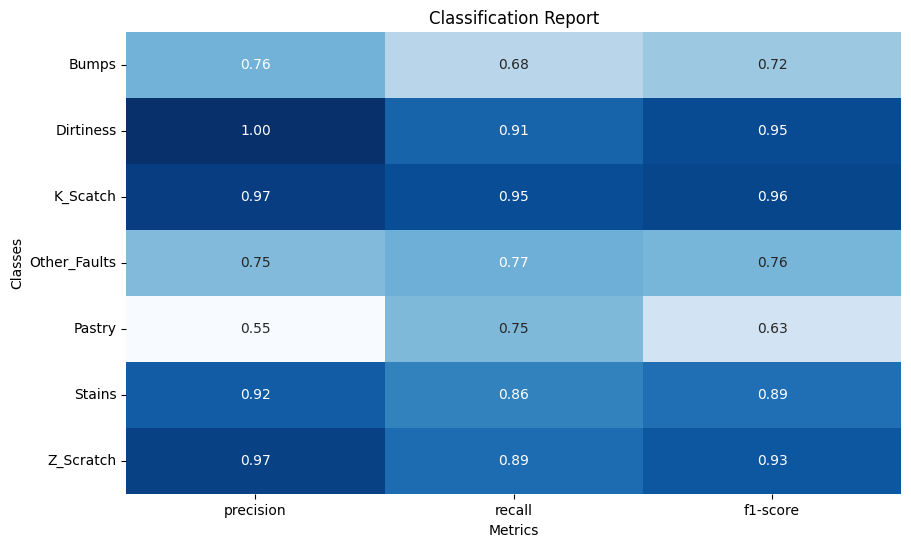

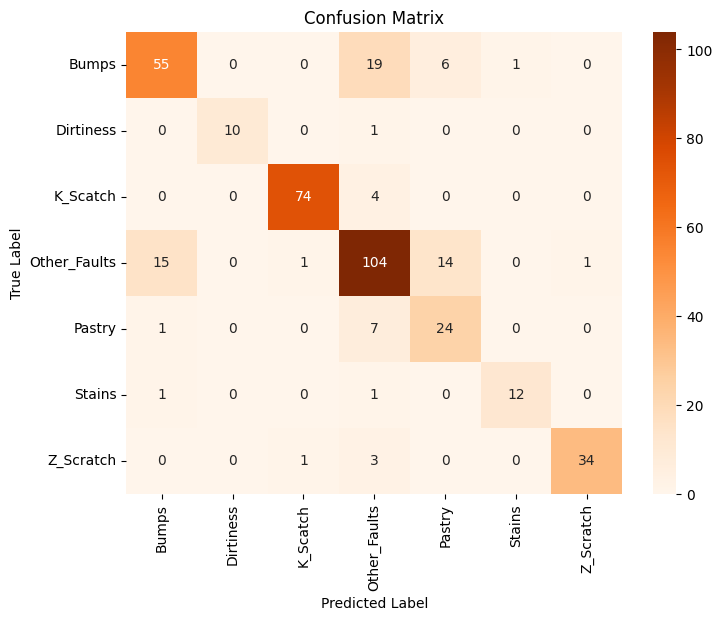

In [73]:


def plot_classification_report(y_true, y_pred, classes):
    # Gera o relatório em dicionário
    report_dict = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    
    # Remove média e accuracy para plotar só as classes
    report_df = pd.DataFrame(report_dict).transpose()
    report_df = report_df.iloc[:-3, :-1]  # tirar accuracy e médias, só classes e métricas
    
    # Plot heatmap do classification report (precision, recall, f1-score)
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df, annot=True, cmap='Blues', cbar=False, fmt='.2f')
    plt.title('Classification Report')
    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.show()
    
    # Matriz de confusão (usando as labels corretas)
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Exemplo de uso:
classes = ['Bumps', 'Dirtiness', 'K_Scatch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch']
plot_classification_report(y_test, y_pred_grid, classes)


[[ 55   0   0  19   6   1   0]
 [  0  10   0   1   0   0   0]
 [  0   0  74   4   0   0   0]
 [ 15   0   1 104  14   0   1]
 [  1   0   0   7  24   0   0]
 [  1   0   0   1   0  12   0]
 [  0   0   1   3   0   0  34]]


<AxesSubplot:>

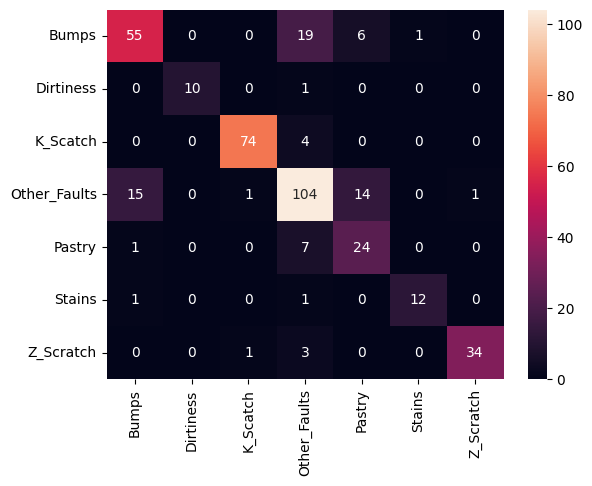

In [74]:
cm = confusion_matrix(y_test, y_pred_grid, labels=ensemble_grid.classes_)
print(cm)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=ensemble_grid.classes_, yticklabels=ensemble_grid.classes_)